## Try FastAI in Feature Exploration

* Confidence of prediction variance
  * It checks the average and the variance of predictions from trees (estimators) in random forests
* Feature Importance
  * importance plot
  * out of bag score
* Visualize Feature Correlation
* Tree Inpertrepter
  * Checks the contribution of each column to the prediction for each row


* Data can be down loaded here (need sign in): https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/
* Reference: https://github.com/fastai/fastai/blob/master/courses/ml1/lesson2-rf_interpretation.ipynb

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
df = pd.read_csv("Big_Mart_Train.csv")
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
# Preprocessing

## fill NA
df.Item_Weight = df.Item_Weight.fillna(np.nanmedian(df.Item_Weight))
df.Outlet_Size = df.Outlet_Size.fillna(df.Outlet_Size.mode().iloc[0])

## standardize values
df.Item_Fat_Content = df.Item_Fat_Content.replace(['low fat', 'LF'], ['Low Fat', 'Low Fat'])
df.Item_Fat_Content = df.Item_Fat_Content.replace(['reg'], ['Regular'])

df.Outlet_Establishment_Year = 2017 - df.Outlet_Establishment_Year

## drop ids
df.drop('Item_Identifier',axis=1, inplace=True)

## label encoding on categorical data
le = LabelEncoder()
for i in df.columns:
    if (df[i].dtype == 'object'):
        df[i] = le.fit_transform(df[i].astype('str'))
        df[i] = df[i].astype('object')

## save target
target_reg = df['Item_Outlet_Sales']  # regression target
def reg2clf(v, threshold):
    if v > threshold:
        return 1
    return 0
target_clf = df['Item_Outlet_Sales'].apply(lambda r: reg2clf(r, df['Item_Outlet_Sales'].median()))  # classification target
df.drop('Item_Outlet_Sales',axis=1, inplace=True)

df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,9.30,0,0.016047,4,249.8092,9,18,1,0,1
1,5.92,1,0.019278,14,48.2692,3,8,1,2,2
2,17.50,0,0.016760,10,141.6180,9,18,1,0,1
3,19.20,1,0.000000,6,182.0950,0,19,1,2,0
4,8.93,0,0.000000,9,53.8614,1,30,0,2,1


### Part 1 - Regression Problem

`Item_Outlet_Sales` as the target, predict its value

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df, target_reg, train_size=0.75, test_size=0.25)

In [6]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

#### Confidence based on tree variance

* Average of the prediction values
* Variance of the tree predictions

In [12]:
%time 
preds = np.stack([t.predict(X_test) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

Wall time: 0 ns


(404.1183472202381, 163.0359701742273)

#### Plot Feature Confidence

* It's in fact using pandas plot, you just need the feature importance is a dataframe.
* Sklearn randomforest can generate feature importance and do the same plot if it's dataframe

In [26]:
fi = rf_feat_importance(m, X_train)
fi

,cols,imp
4,Item_MRP,0.477698
9,Outlet_Type,0.224329
2,Item_Visibility,0.084507
6,Outlet_Establishment_Year,0.052244
0,Item_Weight,0.048596
5,Outlet_Identifier,0.044298
3,Item_Type,0.039882
7,Outlet_Size,0.009944
8,Outlet_Location_Type,0.009899
1,Item_Fat_Content,0.008603


In [27]:
def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False, color='g')

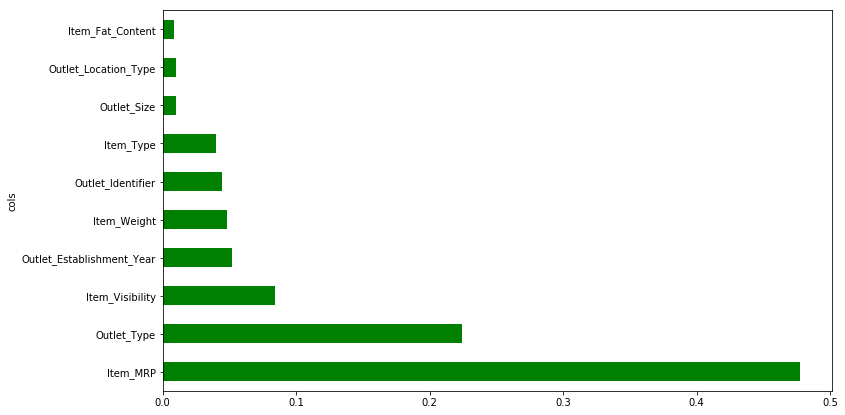

In [28]:
plot_fi(fi)

#### Visualize Feature Correlation

* Closer the clsuters are, higher correlation the features are
* This method can help you understand feature correlation from an overall view, instead of just set thresholds and remove features that exceed the correlation thresholds

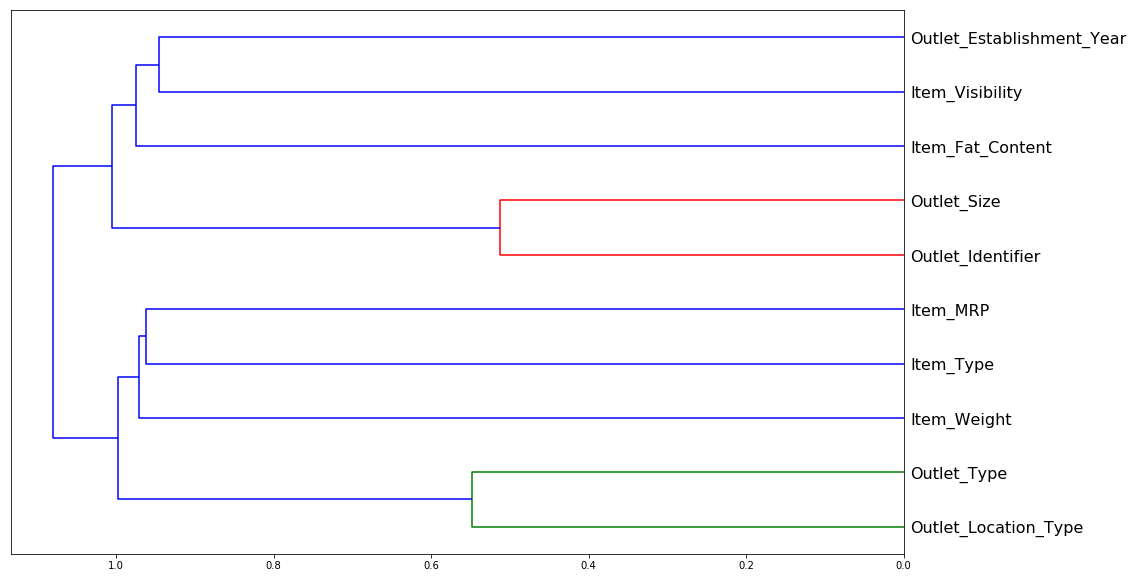

In [25]:
from scipy.cluster import hierarchy as hc

corr = np.round(scipy.stats.spearmanr(df).correlation, 4)  # spearman correlation method
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=16)
plt.show()

#### Out Of Bag Score (OOB Score)

* The idea for OOB score is to calculate error on the training set, but only include the trees in the calculation of a row's error where that row was not included in training that tree. This allows us to see whether the model is over-fitting, without needing a separate validation set.
* The result here can also indicate that Item_MRP is very important to the prediction, because if we remove this feature, the OOB score dropped dramatically

In [32]:
def split_vals(a,n): 
    return a[:n], a[n:]

def get_oob(df, n_trn, y_train):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [43]:
get_oob(X_train, len(X_train), y_train)

0.5677299442004444

In [49]:
# remove each feature and check oob score

for col in X_train.columns:
    print(col, get_oob(X_train.drop(col, axis=1), len(X_train), y_train))

Item_Weight 0.5713917784613173
Item_Fat_Content 0.5677198129328864
Item_Visibility 0.566943607174956
Item_Type 0.5689845284652515
Item_MRP 0.24178487639603063
Outlet_Identifier 0.5687845260441176
Outlet_Establishment_Year 0.5669838849327572
Outlet_Size 0.5623689968537583
Outlet_Location_Type 0.566531219484439
Outlet_Type 0.570907042245696


#### Tree Interpreter

* Predictions are the values predicted by the random forest model
* Bias is the average value of the target variable for the dataset
* Contributions are the amount by which the predicted value was changed by each column. Negative value means negative impact on the prediction.

In [76]:
from treeinterpreter import treeinterpreter as ti

X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)


check_idx = 0
for i in range(len(X_test)):
    if i == check_idx:
        r = X_test.values[None,i]
        print('True Value:', y_test.values[i])
        prediction, bias, contributions = ti.predict(m, r)
        print('Prediction', prediction)
        print('Average of the Prediction', bias)
        print('Contribution:', [elem for elem in zip(X_test.columns, X_test.iloc[0], contributions[0])])
        break

True Value: 372.848
Prediction [404.11835]
Average of the Prediction [2164.10692]
Contribution: [('Item_Weight', 10.695, -40.597745470328526), ('Item_Fat_Content', 0, 0.15675811624203034), ('Item_Visibility', 0.06402288099999999, 3.007057924733971), ('Item_Type', 9, 18.886169172169662), ('Item_MRP', 36.0848, -1659.9895762705426), ('Outlet_Identifier', 3, -46.62306022149405), ('Outlet_Establishment_Year', 8, -84.79638989009132), ('Outlet_Size', 1, -4.23117432936547), ('Outlet_Location_Type', 2, -21.038678096079508), ('Outlet_Type', 2, 75.23806685601942)]


In [83]:
contribution_dct = {}
for i in range(len(X_test)):
    if i == 10:
        break
    r = X_test.values[None,i]
    prediction, bias, contributions = ti.predict(m, r)
    contribution_dct[i] = dict(zip(X_test.columns, contributions[0]))
    
contribution_df = pd.DataFrame(contribution_dct).T
contribution_df.head()

,Item_Fat_Content,Item_MRP,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type
0,0.156758,-1659.989576,18.886169,3.007058,-40.597745,-84.796390,-46.623060,-21.038678,-4.231174,75.238067
1,14.595376,2163.373917,181.788079,410.623988,174.517728,-106.209749,264.838217,38.568468,154.803769,181.276358
2,10.856253,-231.523207,-23.413883,-117.870821,2.321033,-90.857276,-24.716869,-3.992019,-6.461920,97.165480
3,-4.150171,-431.116316,-56.032272,-38.624663,44.665567,-132.963183,-24.746570,-36.007996,-3.515600,49.179011
4,-5.051825,-1242.257340,-20.511018,68.938286,10.999551,-25.449231,75.226096,8.447235,33.234749,111.425028


In [87]:
avg_contribution = contribution_df.apply(np.mean)
avg_contribution

Item_Fat_Content               4.896886
Item_MRP                    -138.811393
Item_Type                     -0.216692
Item_Visibility               41.417366
Item_Weight                   46.718464
Outlet_Establishment_Year    -72.415547
Outlet_Identifier             47.938049
Outlet_Location_Type         -10.002663
Outlet_Size                   22.709071
Outlet_Type                  -84.221599
dtype: float64

## Part 2 - Classification Problem

In [88]:
X_train, X_test, y_train, y_test = train_test_split(df, target_clf, train_size=0.75, test_size=0.25)

In [89]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

#### Confidence of tree variance

* average of predicion value
* variance

In [91]:
%time 
preds = np.stack([t.predict(X_test) for t in m.estimators_])  # each estimator is a tre
print(preds)
np.mean(preds[:,0]), np.std(preds[:,0])

Wall time: 0 ns
[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 1.]
 [0. 1. 1. ... 0. 0. 1.]
 ...
 [1. 1. 1. ... 0. 0. 1.]
 [0. 1. 1. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]]


(0.175, 0.3799671038392666)

#### Tree Interpreter

In [93]:
from treeinterpreter import treeinterpreter as ti

X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)


check_idx = 0
for i in range(len(X_test)):
    if i == check_idx:
        r = X_test.values[None,i]
        print('True Value:', y_test.values[i])
        prediction, bias, contributions = ti.predict(m, r)  # it predicts probability
        print('Prediction', prediction)
        print('Average of the Prediction', bias)
        print('Contribution:', [elem for elem in zip(X_test.columns, X_test.iloc[0], contributions[0])])
        break

True Value: 0
Prediction [[0.78033 0.21967]]
Average of the Prediction [[0.5013 0.4987]]
Contribution: [('Item_Weight', 18.0, array([-0.02467,  0.02467])), ('Item_Fat_Content', 1, array([-0.00761,  0.00761])), ('Item_Visibility', 0.142688846, array([-0.01207,  0.01207])), ('Item_Type', 6, array([ 0.00942, -0.00942])), ('Item_MRP', 88.5514, array([ 0.3259, -0.3259])), ('Outlet_Identifier', 8, array([-0.01055,  0.01055])), ('Outlet_Establishment_Year', 20, array([ 0.01162, -0.01162])), ('Outlet_Size', 2, array([-0.00119,  0.00119])), ('Outlet_Location_Type', 0, array([ 0.00531, -0.00531])), ('Outlet_Type', 1, array([-0.01713,  0.01713]))]


## Summary

* It took me so much time to install FastAI, but it seems that functions I need here do not have to use FastAI
* In tree interpreter, `predict()` is predicting probability, which is good
* `treeinterpreter` is a bit slow, about 1 second per row, it can be used in eyeballing method when you don't have much records to check